In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn.functional as F
import pandas as pd
%matplotlib inline

from utils import read_h5py_folder, augment, resize_fast, get_train_test_data, tumor_data_np, plot_confusion_matrix

/home/dolorousrtur/anaconda3/envs/dipstereo/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
NUM_CLASSES = 3
NUM_ROUTING_ITERATIONS = 3

In [3]:
import h5py
from sklearn.model_selection import train_test_split

f = h5py.File('h5.mat')

images = np.expand_dims(f['image'][()], axis=1)
masks = f['tumorMask'][()]
labels = f['label'][()].astype(np.int32)

images_train, images_test, labels_train, labels_test, masks_train, masks_test = train_test_split(images, labels, masks)

In [4]:
train_data = tumor_data_np(images_train, labels_train, masks_train)
test_data = tumor_data_np(images_test, labels_test, masks_test)

batch_size, n_iters = 25, 700
n_epoches = int(n_iters / (len(train_data)/batch_size))

train_feeder = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_feeder = torch.utils.data.DataLoader(dataset=test_data, batch_size=2, shuffle=False)

In [5]:
def softmax(input, dim=1):
    transposed_input = input.transpose(dim, len(input.size()) - 1)
    softmaxed_output = F.softmax(transposed_input.contiguous().view(-1, transposed_input.size(-1)), dim=-1)
    return softmaxed_output.view(*transposed_input.size()).transpose(dim, len(input.size()) - 1)

In [6]:
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, num_route_nodes, in_channels, out_channels, kernel_size=None, stride=None,
                 num_iterations=3):
        super(CapsuleLayer, self).__init__()

        self.num_route_nodes = num_route_nodes
        self.num_iterations = num_iterations

        self.num_capsules = num_capsules

        if num_route_nodes != -1:
            self.route_weights = nn.Parameter(torch.randn(num_capsules, num_route_nodes, in_channels, out_channels))
        else:
            self.capsules = nn.ModuleList(
                [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=0) for _ in
                 range(num_capsules)])

    def squash(self, tensor, dim=-1):
        squared_norm = (tensor ** 2).sum(dim=dim, keepdim=True)
        scale = squared_norm / (1 + squared_norm)
        return scale * tensor / torch.sqrt(squared_norm)

    def forward(self, x):
        if self.num_route_nodes != -1:
            priors = x[None, :, :, None, :] @ self.route_weights[:, None, :, :, :]

            logits = Variable(torch.zeros(*priors.size())).cuda()
            for i in range(self.num_iterations):
                probs = softmax(logits, dim=2)
                outputs = self.squash((probs * priors).sum(dim=2, keepdim=True))

                if i != self.num_iterations - 1:
                    delta_logits = (priors * outputs).sum(dim=-1, keepdim=True)
                    logits = logits + delta_logits
        else:
            outputs = [capsule(x).view(x.size(0), -1, 1) for capsule in self.capsules]
            outputs = torch.cat(outputs, dim=-1)
            outputs = self.squash(outputs)

        return outputs

In [7]:
class CapsuleNet(nn.Module):
    def __init__(self):
        super(CapsuleNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=9, stride=1)
        self.primary_capsules = CapsuleLayer(num_capsules=8, num_route_nodes=-1, in_channels=256, out_channels=32,
                                             kernel_size=9, stride=2)
        self.digit_capsules = CapsuleLayer(num_capsules=NUM_CLASSES, num_route_nodes=32 * 6 * 6, in_channels=8,
                                           out_channels=16)

        self.decoder = nn.Sequential(
            nn.Linear(16 * NUM_CLASSES, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 784),
            nn.Sigmoid()
        )

    def forward(self, x, y=None):
#         print(type(x.data))
        x = F.relu(self.conv1(x.float()), inplace=True)
        x = self.primary_capsules(x)
        print('xshape',x.shape)
        x = self.digit_capsules(x).squeeze().transpose(0, 1)

        classes = (x ** 2).sum(dim=-1) ** 0.5
        classes = F.softmax(classes, dim=-1)

        if y is None:
            # In all batches, get the most active capsule.
            _, max_length_indices = classes.max(dim=1)
            y = Variable(torch.sparse.torch.eye(NUM_CLASSES)).cuda()
            y = y.index_select(dim=0, index=max_length_indices)

        reconstructions = self.decoder((x * y[:, :, None]).view(x.size(0), -1))

        return classes, reconstructions



In [8]:
class CapsuleLoss(nn.Module):
    def __init__(self):
        super(CapsuleLoss, self).__init__()
        self.reconstruction_loss = nn.MSELoss(size_average=False)

    def forward(self, images, labels, classes, reconstructions):
        left = F.relu(0.9 - classes, inplace=True) ** 2
        right = F.relu(classes - 0.1, inplace=True) ** 2

        margin_loss = labels * left + 0.5 * (1. - labels) * right
        margin_loss = margin_loss.sum()

        assert torch.numel(images) == torch.numel(reconstructions)
        images = images.view(reconstructions.size()[0], -1)
        reconstruction_loss = self.reconstruction_loss(reconstructions, images.float())

        return (margin_loss + 0.0005 * reconstruction_loss) / images.size(0)

In [9]:
model = CapsuleNet().cuda()
criterion = CapsuleLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [10]:
history = list()
classes_pred = []
y_true = []

for epoch in range(n_epoches):
    print(epoch)
    for i,(image, labels) in enumerate(train_feeder):
        
        labels = torch.LongTensor(labels.long())
        labels = torch.sparse.torch.eye(NUM_CLASSES).index_select(dim=0, index=labels.squeeze())

        data = Variable(image).cuda()
        labels = Variable(labels).cuda()
        

        classes, reconstructions = model(data)

        loss = criterion(data, labels, classes, reconstructions)
        loss.backward()
        optimizer.step()
        history.append(loss.cpu().data.numpy())
        

0
xshape torch.Size([25, 18432, 8])


RuntimeError: The size of tensor a (18432) must match the size of tensor b (1152) at non-singleton dimension 2.

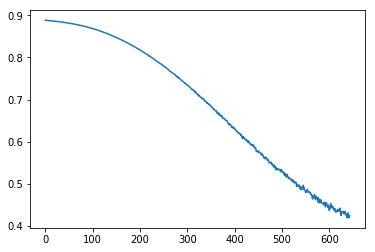

In [18]:
plt.plot(history)

In [19]:
correct, y_pred, y_true = 0, list(), list()

for image, labels in test_feeder:
    
    labels = torch.LongTensor(labels.long())
    labels = torch.sparse.torch.eye(NUM_CLASSES).index_select(dim=0, index=labels.squeeze())

    data = Variable(image).cuda()
    labels = Variable(labels).cuda()
    
    classes, reconstructions = model(data)
    
#     print(classes)
#     print(labels)
    
    pred = np.argmax(classes.data.cpu().numpy(), axis=1)
#     print(pred)
    true = np.argmax(labels.data.cpu().numpy(), axis=1)
#     print(true)
    
    
    correct += (pred == true).sum()
    y_pred.append(pred)
    y_true.append(true)
    
print('Accuracy:', correct/len(test_data))

Accuracy: 0.4490861618798956


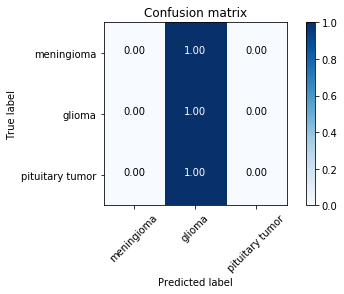

In [20]:
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(cm=confusion_matrix(np.hstack(y_true), np.hstack(y_pred)), classes=['meningioma','glioma','pituitary tumor'])